# Portfolio Optimization and Backtesting With Python

Written by Nathan Ramos, CFA${^®}$, of NR Capital Management, LLC.

Schedule a [FREE consultation](https://calendly.com/nrcapitalmanagement/30min) to see how we can enhance your investment strategy with statistical methods such as what you see below.

## Introduction

**Run this notebook by clicking "Runtime" in the top menu, then click "Run all", or press CTRL + F9.**

 Portfolio optimization is a quantitative process used to select an optimal set of assets from a larger pool to achieve specific investment objectives. The aim is to construct a portfolio that offers the maximum possible expected return for a given level of risk, or equivalently, to minimize risk for a given level of expected return. Traditional methods often rely on Markowitz’s Efficient Frontier, which models the trade-off between risk and return for a set of risky assets. The optimization problem involves input parameters like expected returns, variances, and covariances for the assets under consideration. Constraints may also be added to tailor the optimization to an investor's particular needs. By employing mathematical models and techniques, portfolio optimization helps investors make informed decisions, providing a data-driven foundation for selecting and allocating assets in an investment portfolio. However, these models should be used with caution and be used as a guideline rather than a definitive answer and is best employed in conjunction with other tools and analyses. No model is perfect and the true optimal portfolio may differ from the one computed by a portfolio optimization algorithm.

## Install Libraries

Before we dive into the code, we need to install the libraries that will be utilized throughout this notebook. Running the following cell will install the necessary Python packages:

In [1]:
# %%capture
# !pip install PyPortfolioOpt yahooquery bt ffn

- PyPortfolioOpt: For portfolio optimization algorithms and utility functions.
- yahooquery: To fetch financial data from Yahoo Finance.
- bt: For backtesting portfolio strategies.
- ffn: A financial function library for working with financial data.

Simply run the cell to install these packages. The %%capture magic command will suppress any output, ensuring a clean notebook.

## Import Libraries

Once the packages are installed, we need to import them to start using their features. Run the following cell to import the libraries:

In [2]:
import sys
sys.path.append("../")

from portopt import data
from portopt import utils
from portopt import plotting
from portopt import semivariance as algo
from portopt import backtesting as bkt
import pandas as pd

In [3]:
portfolio_tickers = [
    'SPY', # Stocks
    'BND', # Bonds
    'GLD', # Gold
    'GBTC', # Crypto
    'BTAL' # Anti-Beta
]

In [4]:
weight_bounds = [
    (0, 1.0), # SPY 0-100%
    (0, 1.0), # BND 0-100%
    (0, 0.1), # GLD 0-10%
    (0, 0.05), # GBTC 0-5%
    (0, 0.05) # BTAL 0-5%
]

In [5]:
investor_views = {
    'SPY': 0.0044, # investor expects 0.44% return
    'BND': 0.0500 # investor expects 5.00% return
}

In [6]:
view_confidences = pd.Series({
    'SPY': 0.4415, # investor is 44.15% confident in view
    'BND': 0.5000 # investor is 50.00% confident in view
})

In [7]:
n_portfolios = 1000 
nsim = 1000

In [8]:
historical_prices = data.get_historical_prices(portfolio_tickers)
summary_detail = data.get_summary_details(portfolio_tickers)
risk_free_rate, risk_free_rate_name = data.get_risk_free_rate()
historical_risk_free_rate, risk_free_rate_name = data.get_historical_risk_free_rate()
weight_bounds = data.get_weight_bounds(portfolio_tickers, weight_bounds)

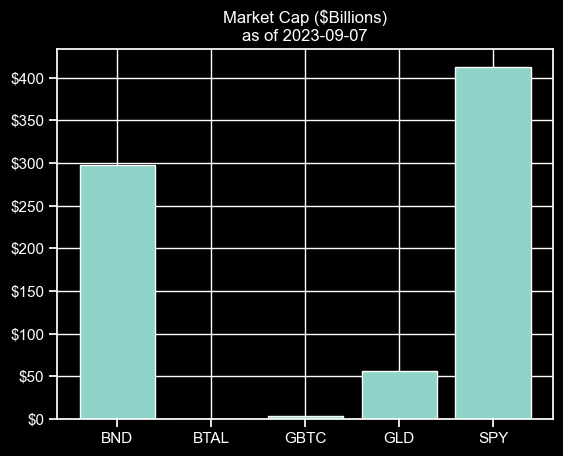

In [9]:
market_caps = data.get_market_caps(summary_detail)
plotting.plot_market_caps(market_caps, historical_prices)

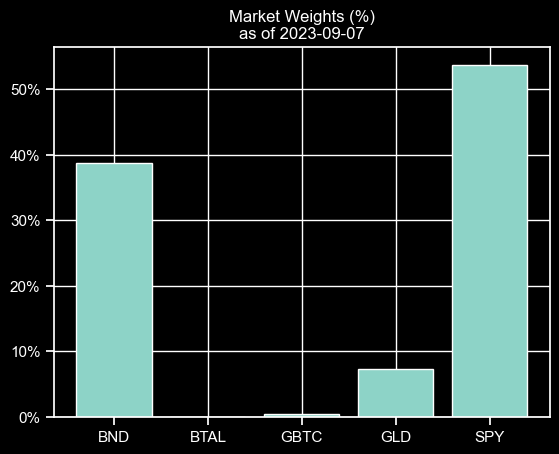

In [10]:
market_cap_weights = data.get_market_cap_weights(market_caps)
plotting.plot_market_weights(market_cap_weights, historical_prices)

In [11]:
benchmark_name = 'Market Cap Weighted Portfolio'
benchmark_portfolio = data.get_benchmark_portfolio(market_cap_weights.to_dict())
benchmark_prices = data.get_historical_prices(benchmark_portfolio.keys())

In [12]:
import pandas as pd
pd.DataFrame.from_dict(benchmark_portfolio, orient='index', columns=[benchmark_name]).squeeze().sort_values(ascending=False)

SPY     0.5368
BND     0.3864
GLD     0.0723
GBTC    0.0043
BTAL    0.0003
Name: Market Cap Weighted Portfolio, dtype: float64

In [13]:
historical_prices, benchmark_prices, historical_risk_free_rate = data.get_historical_data(
    historical_prices, benchmark_prices, historical_risk_free_rate
)

In [14]:
average_historical_return = data.get_average_historical_return(historical_prices)
average_historical_return

symbol
BND     0.0091
BTAL   -0.0027
GBTC    0.5343
GLD     0.0556
SPY     0.1142
dtype: float64

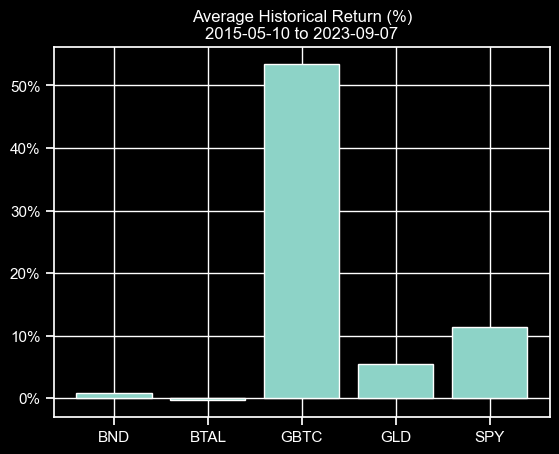

In [15]:
plotting.plot_average_return(average_historical_return, historical_prices)

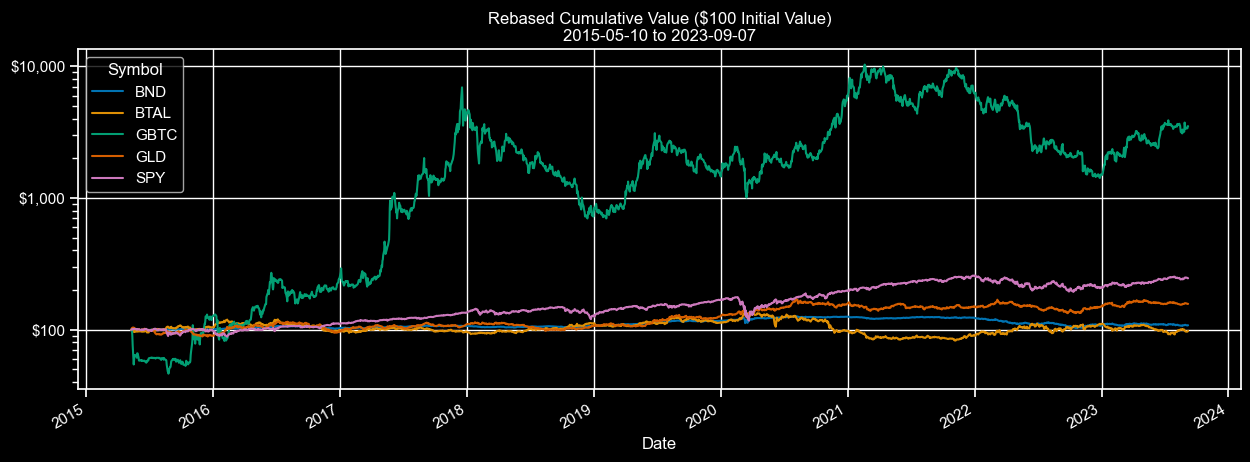

In [16]:
plotting.plot_rebased_cumulative_value(historical_prices, logy=True)

In [17]:
average_risk_free_rate = data.get_average_risk_free_rate(historical_risk_free_rate)

In [18]:
current_prices = data.get_current_prices(portfolio_tickers+list(benchmark_portfolio.keys()))

In [19]:
names = data.get_names(current_prices)

In [20]:
market_prices = data.get_market_prices(historical_prices, market_cap_weights)

In [21]:
covariance_matrix = algo.get_covariance_matrix(historical_prices, method='oracle_approximating')
covariance_matrix

symbol,BND,BTAL,GBTC,GLD,SPY
symbol,,,,,
BND,0.003164,0.000278,0.003442,0.002808,0.001020
BTAL,0.000278,0.025494,-0.021240,0.002294,-0.013990
GBTC,0.003442,-0.021240,0.807587,0.013211,0.038012
GLD,0.002808,0.002294,0.013211,0.019747,0.000840
SPY,0.001020,-0.013990,0.038012,0.000840,0.034290


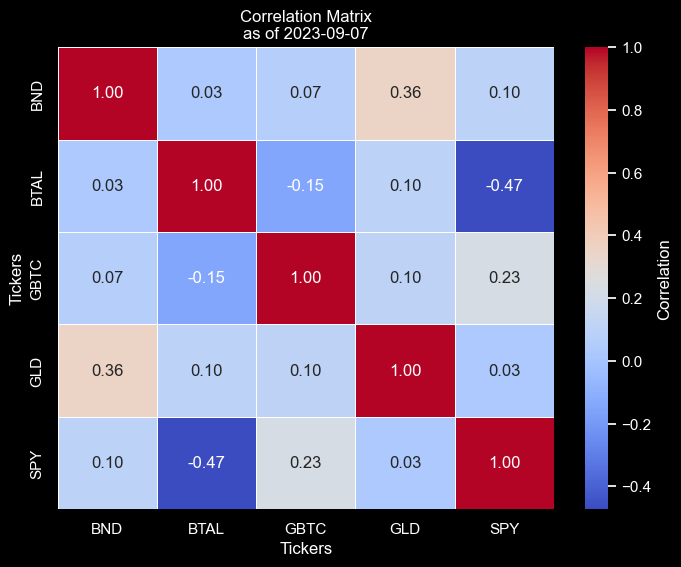

In [22]:
plotting.plot_correlation_matrix(covariance_matrix, historical_prices)

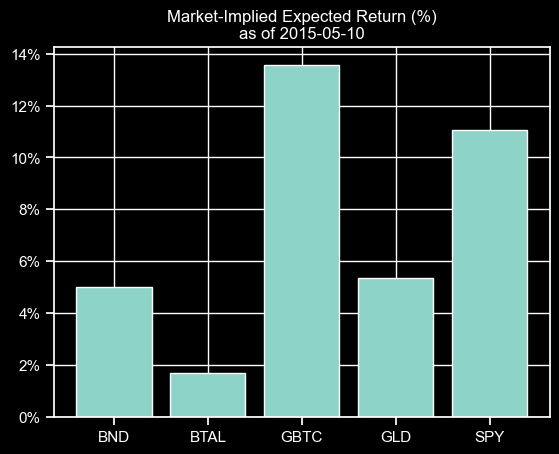

In [23]:
market_risk_aversion, market_implied_expected_returns = algo.get_market_implied_metrics(
    market_prices,
    market_caps,
    covariance_matrix,
    risk_free_rate
)
plotting.plot_market_implied_expected_returns(market_implied_expected_returns, historical_prices)

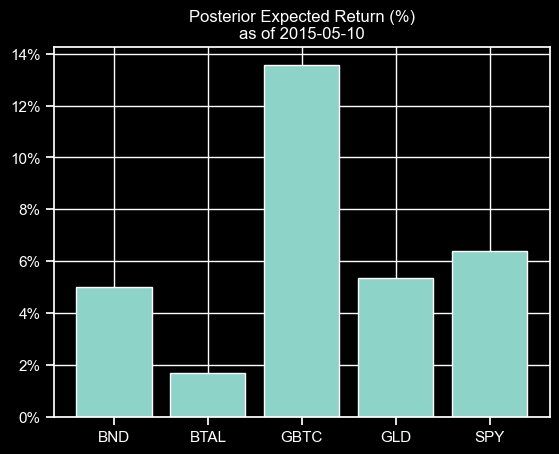

In [24]:
posterior_covariance_matrix, posterior_expected_returns = algo.get_black_litterman_params(
    covariance_matrix,
    portfolio_tickers,
    investor_views,
    market_risk_aversion,
    market_caps,
    risk_free_rate,
    view_confidences,
    market_implied_expected_returns
)
plotting.plot_posterior_expected_returns(posterior_expected_returns, historical_prices)

In [25]:
min_risk, min_risk_weights = algo.get_min_risk_portfolio(
    posterior_expected_returns,
    historical_prices,
    weight_bounds,
    risk_free_rate
)

In [26]:
max_risk = algo.get_max_risk(
    posterior_expected_returns,
    historical_prices,
    weight_bounds,
    risk_free_rate,
    min_risk
)

1it [00:00,  2.54it/s]C:\Users\25del\anaconda3\envs\nrcapital\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
10it [00:02,  4.50it/s]


In [27]:
performance_df_optimal, weights_df_optimal = algo.optimize_portfolio(
    posterior_expected_returns,
    historical_prices,
    weight_bounds,
    risk_free_rate
)

1it [00:00,  2.54it/s]C:\Users\25del\anaconda3\envs\nrcapital\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
10it [00:02,  4.63it/s]
1it [00:00,  2.50it/s]C:\Users\25del\anaconda3\envs\nrcapital\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
99it [00:27,  3.63it/s]


In [28]:
performance_df_optimal

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Expected annual return,0.0495,0.0502,0.0513,0.0520,0.0523,0.0528,0.0532,0.0536,0.0540,0.0543,...,0.0666,0.0667,0.0668,0.0669,0.0670,0.0671,0.0672,0.0672,0.0673,0.0674
Annual semi-deviation,0.0370,0.0375,0.0390,0.0401,0.0406,0.0416,0.0426,0.0437,0.0446,0.0457,...,0.1280,0.1290,0.1301,0.1311,0.1321,0.1331,0.1341,0.1351,0.1361,0.1371
Sortino ratio,0.1795,0.1936,0.2155,0.2269,0.2314,0.2380,0.2425,0.2458,0.2480,0.2498,...,0.1855,0.1847,0.1839,0.1831,0.1824,0.1816,0.1808,0.1801,0.1794,0.1787


In [29]:
algo.get_ef_portfolios(names, weights_df_optimal)

,shortName,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
BND,Vanguard Total Bond Market ETF,0.8571,0.8182,0.8369,0.8487,0.8427,0.8223,0.8051,0.7898,0.7770,...,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.00
BTAL,AGF U.S. Market Neutral Anti-Be,0.0500,0.0497,0.0202,0.0026,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.00
GBTC,GRAYSCALE BITCOIN TRUST BTC,0.0000,0.0036,0.0057,0.0069,0.0086,0.0128,0.0164,0.0198,0.0226,...,0.0500,0.0500,0.0500,0.0500,0.05,0.0500,0.0500,0.0500,0.0500,0.05
GLD,SPDR Gold Trust,0.0086,0.0271,0.0388,0.0456,0.0494,0.0568,0.0627,0.0678,0.0719,...,0.0737,0.0653,0.0564,0.0483,0.04,0.0319,0.0235,0.0155,0.0077,0.00
SPY,SPDR S&P 500,0.0843,0.1013,0.0983,0.0963,0.0993,0.1081,0.1158,0.1226,0.1285,...,0.8763,0.8847,0.8936,0.9017,0.91,0.9181,0.9265,0.9345,0.9423,0.95


In [30]:
optimal_portfolio_index, optimal_portfolio_details, optimal_weights = algo.get_optimal_portfolio(
    performance_df_optimal,
    weights_df_optimal,
    print_output=True
)

The optimal portfolio is Portfolio 17 with the following details:
Expected annual return    0.0563
Annual semi-deviation     0.0529
Sortino ratio             0.2529
Name: 17, dtype: float64


The optimal weights in Portfolio 17: 
symbol
BND     0.6909
BTAL    0.0000
GBTC    0.0417
GLD     0.0980
SPY     0.1694
Name: 17, dtype: float64


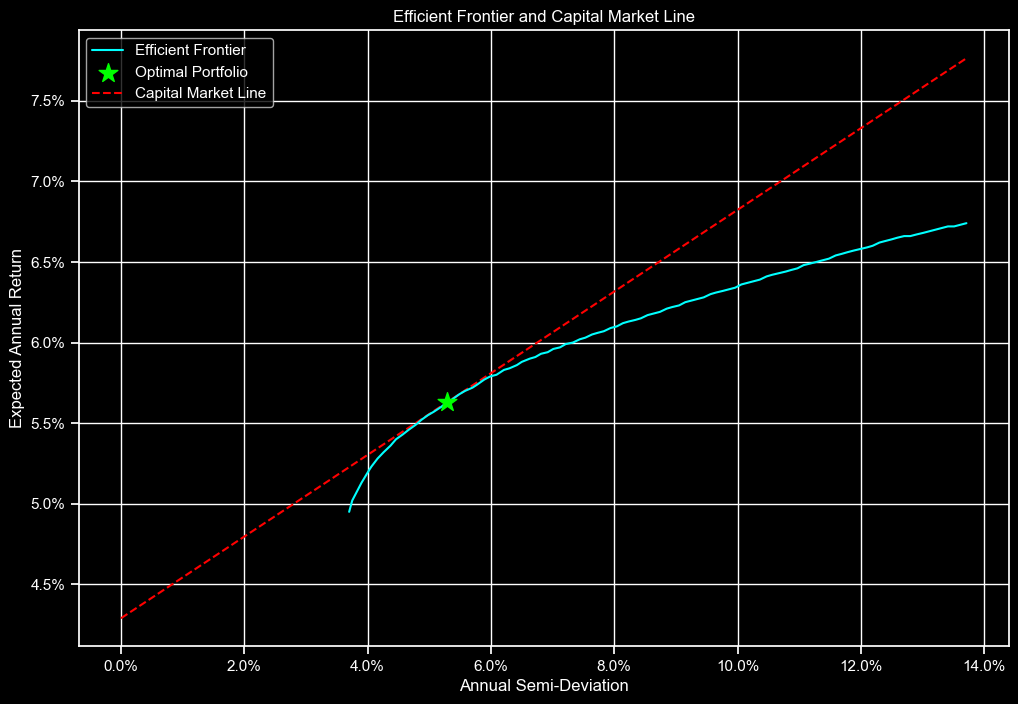

In [31]:
plotting.plot_efficient_frontier(performance_df_optimal, optimal_portfolio_index, risk_free_rate, optimal_color='lime')

In [32]:
weights_df_mc, optimal_portfolio_index_mc, optimal_portfolio_mc, performance_df_mc = algo.generate_optimal_portfolio(
    historical_prices,
    posterior_expected_returns,
    weight_bounds,
    risk_free_rate,
    n_portfolios
)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.89it/s]


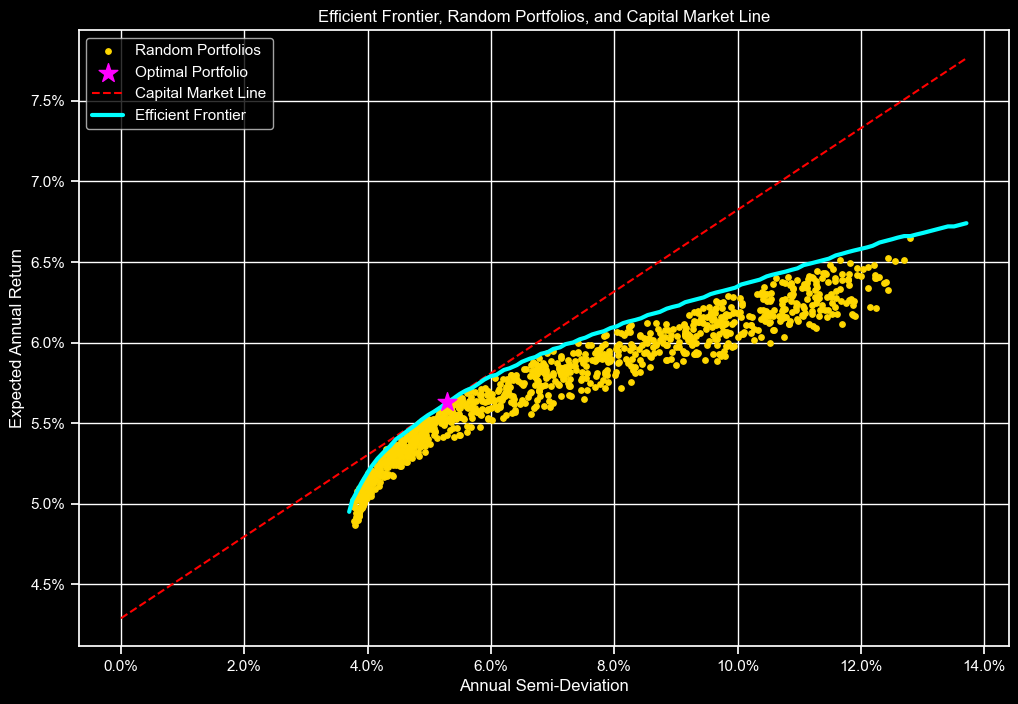

In [33]:
plotting.plot_random_portfolios(
    performance_df_mc,
    optimal_portfolio_details,
    performance_df_optimal,
    risk_free_rate, 
    optimal_color='magenta'
)

In [34]:
strategy_backtest = bkt.optimal_strategy(
    weights_df_optimal,
    optimal_portfolio_index,
    historical_prices,
    strategy_name='Optimal Portfolio'
)

In [35]:
benchmark_backtest = bkt.benchmark_strategy(benchmark_name, benchmark_portfolio, benchmark_prices)

In [36]:
random_strategy = bkt.generate_random_strategy_with_bounds(
        weight_bounds
)

In [37]:
results_with_benchmark_strategy = bkt.run_backtest_with_benchmark(
    strategy_backtest,
    benchmark_backtest,
    average_risk_free_rate
)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.39it/s]


In [38]:
results_with_random_benchmarks = bkt.run_backtest_with_random_benchmarks(
    strategy_backtest, 
    random_strategy, 
    average_risk_free_rate, 
    nsim
)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:46<00:00,  2.46it/s]


In [39]:
bkt.display_results(results_with_benchmark_strategy)

Stat                 Optimal Portfolio    Market Cap Weighted Portfolio
-------------------  -------------------  -------------------------------
Start                2015-05-09           2015-05-09
End                  2023-09-07           2023-09-07
Risk-free rate       2.22%                2.22%

Total Return         80.22%               84.05%
Daily Sharpe         0.68                 0.55
Daily Sortino        1.06                 0.83
CAGR                 7.33%                7.60%
Max Drawdown         -21.08%              -20.11%
Calmar Ratio         0.35                 0.38

MTD                  -0.34%               -0.85%
3m                   1.06%                1.64%
6m                   5.26%                7.58%
YTD                  8.60%                10.35%
1Y                   5.82%                7.84%
3Y (ann.)            0.73%                4.72%
5Y (ann.)            5.33%                7.36%
10Y (ann.)           -                    -
Since Incep. (ann.)  7.33%  

In [40]:
results_with_benchmark_strategy.stats

,Optimal Portfolio,Market Cap Weighted Portfolio
start,2015-05-09 00:00:00,2015-05-09 00:00:00
end,2023-09-07 00:00:00,2023-09-07 00:00:00
rf,0.0222,0.0222
total_return,0.802172,0.840528
cagr,0.073255,0.075972
max_drawdown,-0.210835,-0.201116
calmar,0.347453,0.377751
mtd,-0.003446,-0.008504
three_month,0.010559,0.016389
six_month,0.052559,0.075792


In [41]:
bkt.get_series_from_object(results_with_benchmark_strategy)

,Optimal Portfolio,Market Cap Weighted Portfolio
2015-05-10,100.000000,100.000000
2015-05-11,99.944640,99.853600
2015-05-12,100.011851,99.967123
2015-05-13,100.043398,100.605401
2015-05-14,99.786374,100.781590
...,...,...
2023-09-03,180.840362,185.631304
2023-09-04,179.905372,184.701328
2023-09-05,179.500560,183.895832
2023-09-06,180.130722,183.879944


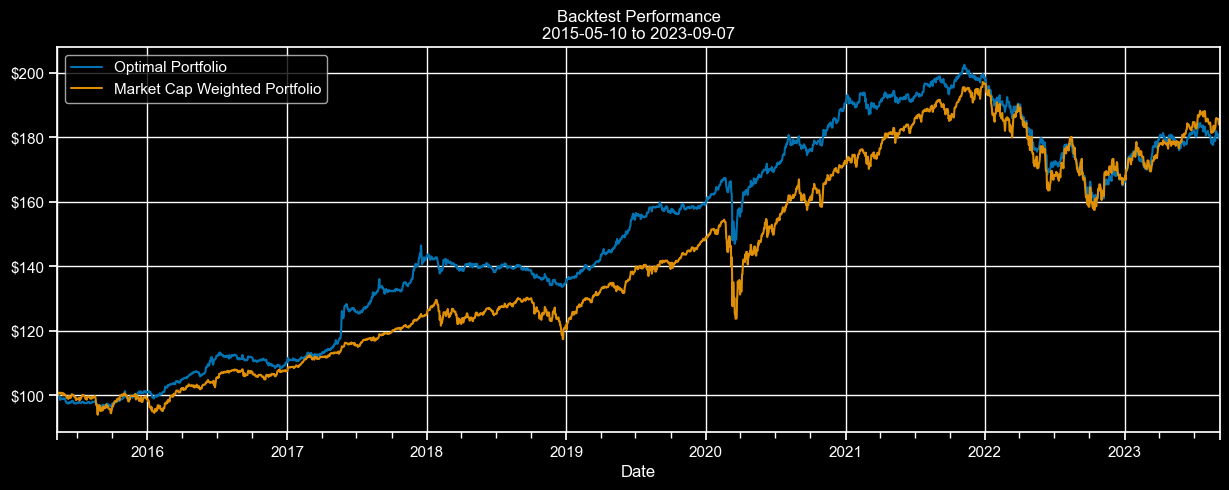

In [42]:
plotting.plot_backtest(results_with_benchmark_strategy, logy=False, title='Backtest Performance')

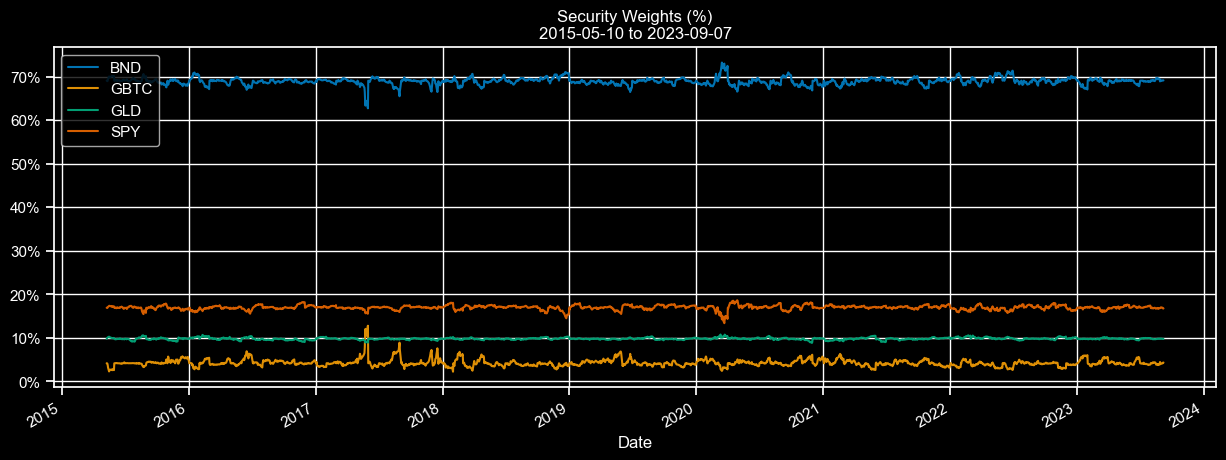

In [43]:
plotting.plot_security_weights(results_with_random_benchmarks, backtest=1)

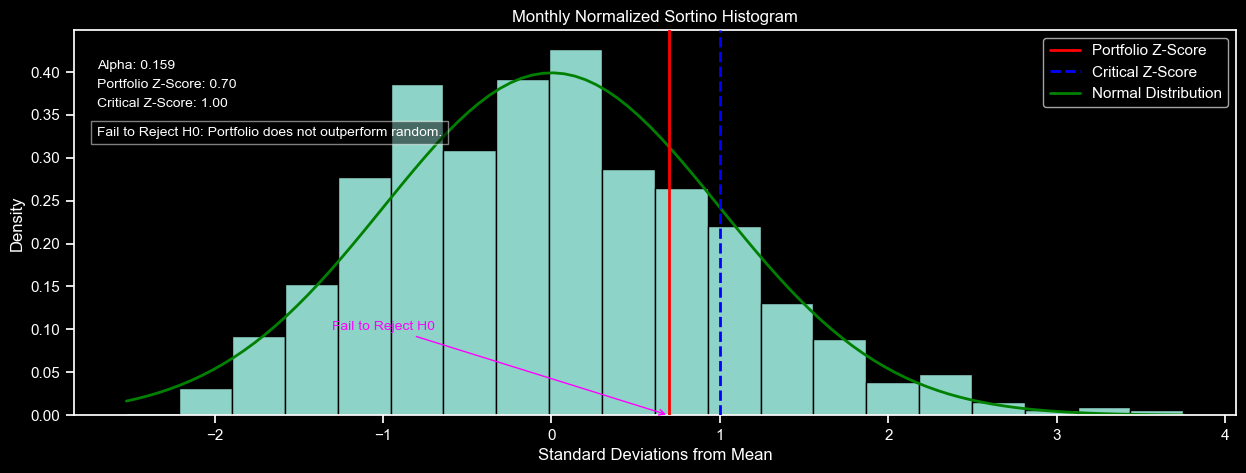

In [44]:
plotting.plot_normalized_histogram(
    results_with_random_benchmarks, statistic='monthly_sortino', alpha=0.159, color_scheme='white')

In [45]:
r_stats, b_stats, random_stats = utils.hypothesis_test_parameters(results_with_random_benchmarks)

Random Portfolios' Stats
random_165            2.44825
random_416           2.345628
random_836           2.321772
random_40            2.317607
random_7             2.276859
                       ...   
random_633           1.297102
random_240           1.294246
random_939           1.292639
random_628           1.291764
Optimal Portfolio    1.290014
Name: monthly_sortino, Length: 233, dtype: object

Optimal Portfolio: monthly_sortino
1.29

Random Portfolios' Mean, Standard Deviation, and Mean + Standard Deviation
1.0262
0.3791
1.4054

Optimal Portfolio Z-Score
0.6957


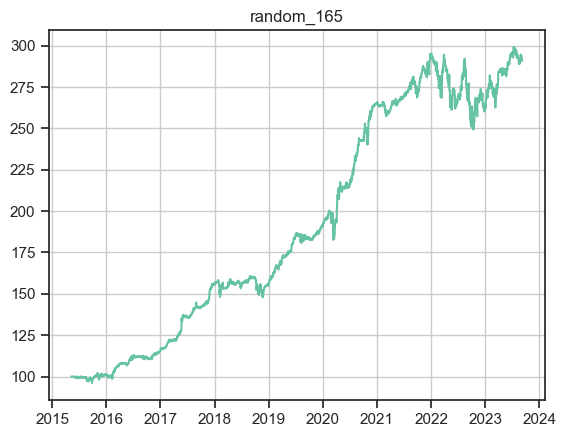

In [46]:
utils.plot_hypothesis_test(results_with_random_benchmarks, random_stats, chart_num=0)

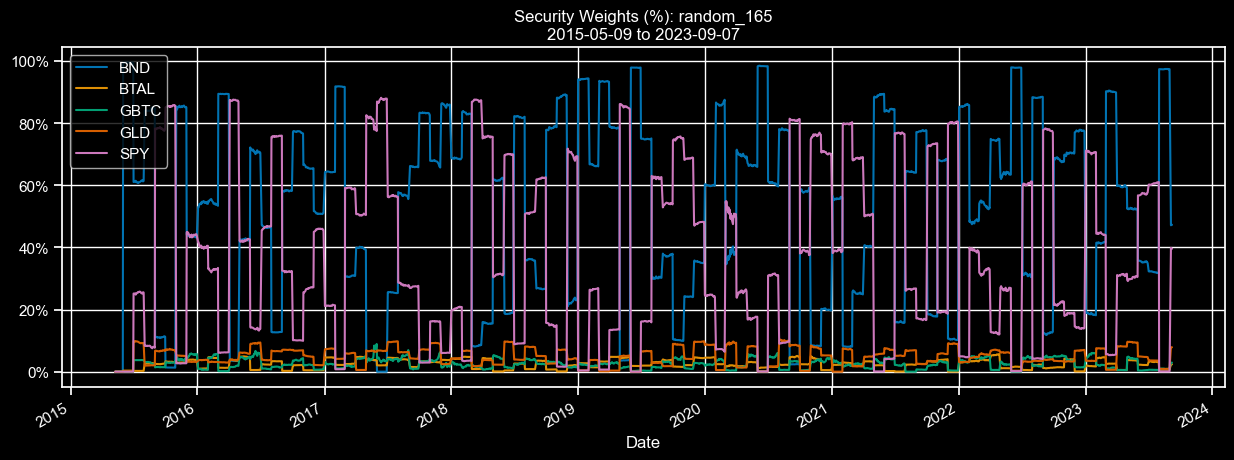

In [47]:
utils.plot_hypothesis_test(results_with_random_benchmarks, random_stats, chart_num=1)